In [1]:
import sqlite3
import pandas as pd
from sqlalchemy import create_engine, Table, MetaData
from sqlalchemy.orm import sessionmaker
from IPython.display import display
import matplotlib.pyplot as plt


engine = create_engine('sqlite:///database.sqlite')  

metadata = MetaData()

Session = sessionmaker(bind=engine)
session = Session()

Country_table = session.query(Table('Country', metadata, autoload_with=engine))
League_table = session.query(Table('League', metadata, autoload_with=engine))
Match_table = session.query(Table('Match', metadata, autoload_with=engine))
Player_table = session.query(Table('Player', metadata, autoload_with=engine))
Player_Attributes_table = session.query(Table('Player_Attributes', metadata, autoload_with=engine))
Team_table = session.query(Table('Team', metadata, autoload_with=engine))
Team_Attributes_table = session.query(Table('Team_Attributes', metadata, autoload_with=engine))

In [2]:
Country_df = pd.DataFrame(Country_table)
League_df = pd.DataFrame(League_table)
Match_df = pd.DataFrame(Match_table)
Player_df = pd.DataFrame(Player_table)
Player_Attributes_df = pd.DataFrame(Player_Attributes_table)
Team_df = pd.DataFrame(Team_table)
Team_Attributes_df = pd.DataFrame(Team_Attributes_table)

In [3]:
player_name = Player_df[['player_api_id','player_name']]
Team_name = Team_df[['team_api_id','team_long_name']]
League_name = League_df[['country_id','name']]

In [4]:
import xml.etree.ElementTree as ET
# card_table = Match_df.dropna(subset=['card']) 
# card_table = card_table[card_table['card'].str.strip() != '<card />']  
# card = card_table['card']

goal_table = Match_df.dropna(subset=['goal'])
goal = goal_table['goal']

possession_table = Match_df.dropna(subset=['possession'])  
possession = possession_table[possession_table['possession'].str.strip() != '<possession />']  

possession = possession['possession']








def parse_possession_data(xml_data):
    try:
        root = ET.fromstring(xml_data)  # Parse the XML data
    except ET.ParseError as e:
        print(f"Error parsing XML: {e}")
        return pd.DataFrame()  # Return empty DataFrame if parsing fails

    possession_data = []
    
    # Iterate over each 'value' entry under the 'possession' root
    for value in root.findall('value'):
        possession_info = {
            'Comment': value.find('comment').text if value.find('comment') is not None else None,
            'EventIncidentType': value.find('event_incident_typefk').text if value.find('event_incident_typefk') is not None else None,
            'ElapsedTime': value.find('elapsed').text if value.find('elapsed') is not None else None,
            'Subtype': value.find('subtype').text if value.find('subtype') is not None else None,
            'SortOrder': value.find('sortorder').text if value.find('sortorder') is not None else None,
            'AwayPos': value.find('awaypos').text if value.find('awaypos') is not None else None,
            'HomePos': value.find('homepos').text if value.find('homepos') is not None else None,
            'EventNumber': value.find('n').text if value.find('n') is not None else None,
            'Type': value.find('type').text if value.find('type') is not None else None,
            'ID': value.find('id').text if value.find('id') is not None else None,
        }
        possession_data.append(possession_info)
    
    df_possession = pd.DataFrame(possession_data)  # Create DataFrame from the extracted data
    return df_possession
    
def parse_goals_to_table(xml_data):
    root = ET.fromstring(xml_data)
    
    goal_data = []
    
    for value in root.findall('value'):
        goal_info = {}
        goal_info['goals'] = value.find('stats/goals').text if value.find('stats/goals') is not None else None
        goal_info['player1'] = value.find('player1').text if value.find('player1') is not None else None
        goal_info['player2'] = value.find('player2').text if value.find('player2') is not None else None
        goal_info['team'] = value.find('team').text if value.find('team') is not None else None        
        if goal_info:
            goal_data.append(goal_info)
    df = pd.DataFrame(goal_data)
    return df
    
# def parse_card_data(xml_data):
#     try:
#         root = ET.fromstring(xml_data) 
#     except ET.ParseError as e:
#         print(f"Error parsing XML: {e}")
#         return pd.DataFrame()  

#     cards_data = []
    
#     for value in root.findall('value'):
#         card_info = {
#             'YCards': value.find('stats/ycards').text if value.find('stats/ycards') is not None else None,
#             'EventIncidentType': value.find('event_incident_typefk').text if value.find('event_incident_typefk') is not None else None,
#             'ElapsedTime': value.find('elapsed').text if value.find('elapsed') is not None else None,
#             'CardType': value.find('card_type').text if value.find('card_type') is not None else None,
#             'Subtype': value.find('subtype').text if value.find('subtype') is not None else None,
#             'Player1': value.find('player1').text if value.find('player1') is not None else None,
#             'SortOrder': value.find('sortorder').text if value.find('sortorder') is not None else None,
#             'Team': value.find('team').text if value.find('team') is not None else None,
#             'EventNumber': value.find('n').text if value.find('n') is not None else None,
#             'Type': value.find('type').text if value.find('type') is not None else None,
#             'ID': value.find('id').text if value.find('id') is not None else None,
#             'Comment': value.find('comment').text if value.find('comment') is not None else None,
#         }
#         cards_data.append(card_info)
    
#     df_cards = pd.DataFrame(cards_data)  # Create DataFrame from the extracted data
#     return df_cards



In [5]:

all_cards_tables = []
all_goals_tables = []  
all_possession_tables = []

for i, s in enumerate(goal):
    df2 = parse_goals_to_table(s)
    df2['id_match'] = goal_table.index[i]  
    all_goals_tables.append(df2)  
final_goals_table = pd.concat(all_goals_tables, ignore_index=True)


# for i, s in enumerate(card):
#     df2 = parse_card_data(s)
#     if not df2.empty:  
#         df2['id_match'] = card_table.index[i]
#         all_cards_tables.append(df2)
# final_cards_table = pd.concat(all_cards_tables, ignore_index=True, sort=False)


for i, s in enumerate(possession):
    df2 = parse_possession_data(s)
    if not df2.empty:  
        df2['id_match'] = possession_table.index[i]  
        all_possession_tables.append(df2)

final_possession_table = pd.concat(all_possession_tables, ignore_index=True, sort=False)


In [6]:
final_goals_table

,goals,player1,player2,team,id_match
0,1,37799,38807,10261,1728
1,1,24148,24154,10260,1728
2,1,26181,39297,9825,1729
3,1,30853,30889,8650,1730
4,1,23139,36394,8654,1731
...,...,...,...,...,...
39975,1,37554,None,10192,25947
39976,1,493418,None,9824,25948
39977,1,197757,None,10243,25948
39978,1,198082,None,10243,25948


analys_players

In [7]:
final_goals_table['goals'] = pd.to_numeric(final_goals_table['goals'])
final_goals_table['goals'] = final_goals_table['goals'].fillna(1)
player_goal = final_goals_table.groupby('player1')['goals'].sum().reset_index()
player_assist = final_goals_table.groupby('player2')['goals'].sum().reset_index().rename(columns={'goals': 'assist'})

player_name['player_api_id'] = player_name['player_api_id'].astype(str)
player_goal = pd.merge(player_name, player_goal, left_on='player_api_id', right_on='player1', how='inner')
player_assist = pd.merge(player_name, player_assist, left_on='player_api_id', right_on='player2', how='inner')
player_goal = player_goal.sort_values(by='goals', ascending=False) 
player_assist = player_assist.sort_values(by='assist', ascending=False) 

/tmp/ipykernel_110947/273191010.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_name['player_api_id'] = player_name['player_api_id'].astype(str)


In [8]:
player_goal = player_goal.head(10)
player_assist = player_assist.head(10)

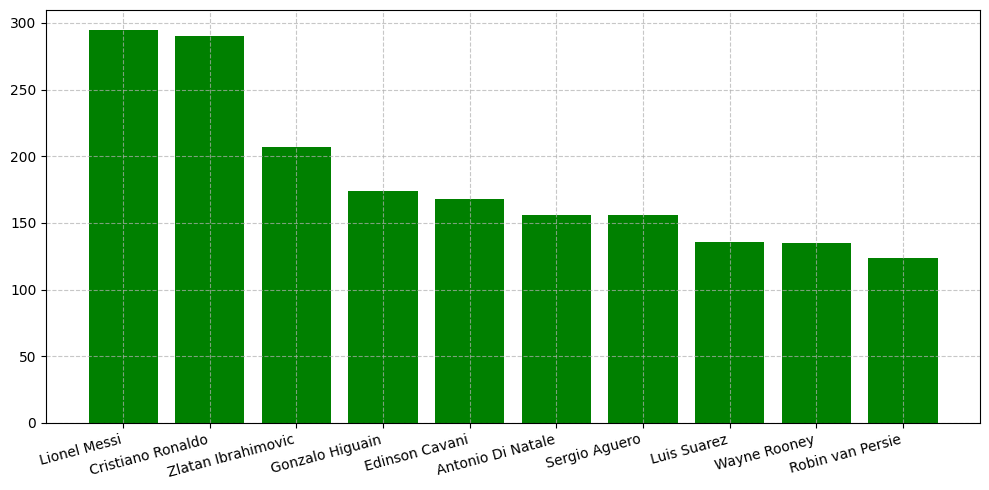

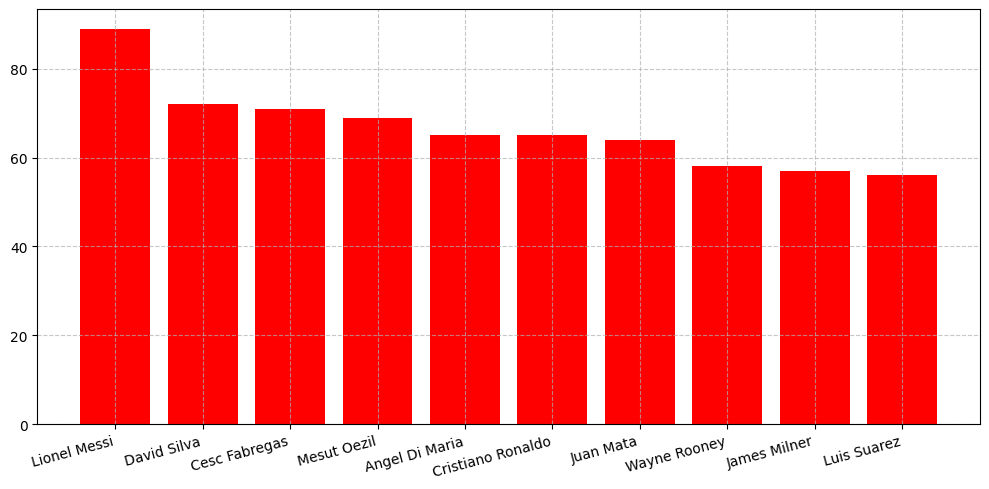

In [9]:
plt.figure(figsize=(10, 5))
plt.bar(player_goal['player_name'], player_goal['goals'], color='green')
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
#
plt.figure(figsize=(10, 5))
plt.bar(player_assist['player_name'], player_assist['assist'], color='red')
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [10]:


aligned_df1 = final_goals_table.set_index('id_match').join(Match_df, how='inner')
aligned_df1 = aligned_df1[['season','player1','goals','player2','team']] 
aligned_df1 = aligned_df1.rename(columns={'Player1': 'Score_the_goal', 'player2': 'assist'})

card_one = final_cards_table[['id_match','Comment','Player1','Team']]
card_one = card_one.rename(columns={'Player1': 'Player_t_card', 'Comment': 'CardType'})

aligned_df1 = aligned_df1.sort_values(by='season', ascending=True) 

player_name['player_api_id'] = player_name['player_api_id'].astype(str)
aligned_df1 = pd.merge(player_name, aligned_df1, left_on='player_api_id', right_on='player1', how='inner')
aligned_df1 = aligned_df1.rename(columns={'player_name': 'player_Score_the_goal'}) 
aligned_df1.drop(columns=['player_api_id', 'player1'], inplace=True)
aligned_df1 = pd.merge(player_name, aligned_df1, left_on='player_api_id', right_on='assist', how='inner')
aligned_df1.drop(columns=['player_api_id', 'assist'], inplace=True)
aligned_df1 = aligned_df1.rename(columns={'player_name': 'player_assist'}) 

aligned_df1=aligned_df1[['season', 'player_assist', 'player_Score_the_goal', 'goals', 'team']]

/tmp/ipykernel_110947/2382900370.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_name['player_api_id'] = player_name['player_api_id'].astype(str)


In [11]:
aligned_df1 = aligned_df1.groupby(['season', 'player_Score_the_goal'])[['goals']].sum().reset_index()
aligned_df1 = aligned_df1.sort_values(by=['season', 'goals'], ascending=[True, False])

In [12]:
aligned_df1

,season,player_Score_the_goal,goals
451,2008/2009,Samuel Eto'o,18.0
380,2008/2009,Nicolas Anelka,17.0
499,2008/2009,Thierry Henry,15.0
531,2008/2009,Zlatan Ibrahimovic,15.0
112,2008/2009,David Villa,14.0
...,...,...,...
6114,2015/2016,Yoann Gourcuff,1.0
6117,2015/2016,Younes Belhanda,1.0
6120,2015/2016,Youssef El Jebli,1.0
6124,2015/2016,Yuya Osako,1.0


/tmp/ipykernel_110947/2646385996.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(player_per_season_g_dict))


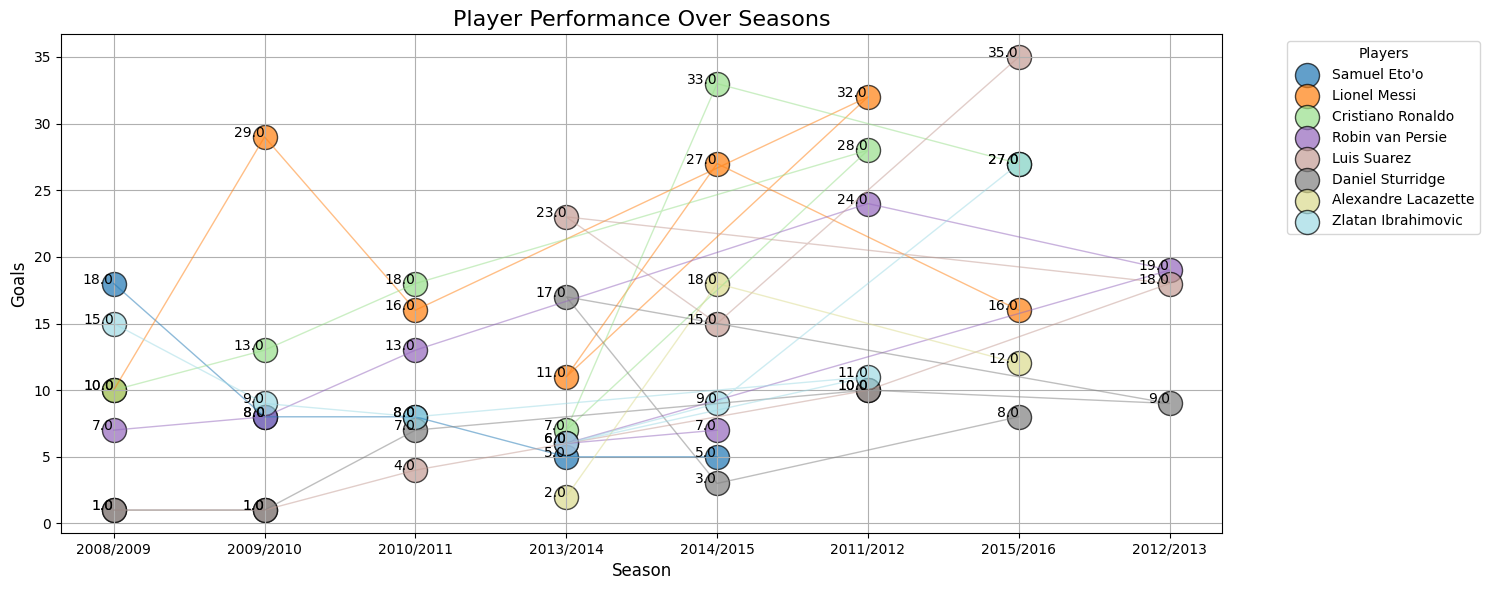

In [13]:
def create_player_per_season_dict(players_analys):
    player_per_season_dict = {}
    seen_players = []
    for index, row in players_analys.iterrows():
        season = row['season']
        player_name = row['player_Score_the_goal']
        # Add player to the dictionary if this is the first time the player appears in the season
        if season not in player_per_season_dict and player_name not in seen_players:
            player_per_season_dict[season] = player_name
            seen_players.append(player_name)
    return player_per_season_dict
    
player_per_season_g_dict = create_player_per_season_dict(aligned_df1)

plt.figure(figsize=(15, 6))
colors = plt.cm.get_cmap('tab20', len(player_per_season_g_dict))
for i, player in enumerate(player_per_season_g_dict.values()):
    df = aligned_df1[aligned_df1['player_Score_the_goal'] == player]
    plt.scatter(df["season"], df["goals"], label=f"{player}", color=colors(i), s=300, edgecolors='black', alpha=0.7)
    plt.plot(df["season"], df["goals"], color=colors(i), linewidth=1, alpha=0.5)  # Make line thinner with linewidth=1
    for j in range(len(df)):
        plt.text(df["season"].iloc[j], df["goals"].iloc[j], f'{df["goals"].iloc[j]}', fontsize=10, ha='right')
plt.title(f"Player Performance Over Seasons", fontsize=16)
plt.xlabel("Season", fontsize=12)
plt.ylabel("Goals", fontsize=12)
plt.legend(title="Players", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()  
plt.show()

In [14]:
Player_A_merged_df = Player_Attributes_df[[
    'player_api_id','date','overall_rating', 'potential', 'gk_reflexes', 'gk_diving', 'standing_tackle',
    'interceptions', 'finishing', 'positioning'
]]
       

Player_A_merged_df['date'] = pd.to_datetime(Player_A_merged_df['date'])

def get_season(date):
    year = date.year
    if date.month <= 6:
        return f'{year - 1}/{year}'
    else:
        return f'{year}/{year + 1}'

Player_A_merged_df['season'] = Player_A_merged_df['date'].apply(get_season)

/tmp/ipykernel_110947/3908333959.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Player_A_merged_df['date'] = pd.to_datetime(Player_A_merged_df['date'])
/tmp/ipykernel_110947/3908333959.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Player_A_merged_df['season'] = Player_A_merged_df['date'].apply(get_season)


In [15]:
Player_A_merged_df

,player_api_id,date,overall_rating,potential,gk_reflexes,gk_diving,standing_tackle,interceptions,finishing,positioning,season
0,505942,2016-02-18,67.0,71.0,8.0,6.0,69.0,70.0,44.0,45.0,2015/2016
1,505942,2015-11-19,67.0,71.0,8.0,6.0,69.0,70.0,44.0,45.0,2015/2016
2,505942,2015-09-21,62.0,66.0,8.0,6.0,66.0,41.0,44.0,45.0,2015/2016
3,505942,2015-03-20,61.0,65.0,7.0,5.0,63.0,40.0,43.0,44.0,2014/2015
4,505942,2007-02-22,61.0,65.0,7.0,5.0,63.0,40.0,43.0,44.0,2006/2007
...,...,...,...,...,...,...,...,...,...,...,...
183973,39902,2009-08-30,83.0,85.0,20.0,9.0,31.0,78.0,77.0,86.0,2009/2010
183974,39902,2009-02-22,78.0,80.0,20.0,9.0,31.0,64.0,76.0,72.0,2008/2009
183975,39902,2008-08-30,77.0,80.0,20.0,9.0,31.0,64.0,71.0,72.0,2008/2009
183976,39902,2007-08-30,78.0,81.0,20.0,9.0,32.0,63.0,64.0,68.0,2007/2008


In [16]:
Player_A_merged_df['player_api_id'] = Player_A_merged_df['player_api_id'].astype(str)
Player_A_merged_df = pd.merge(player_name, Player_A_merged_df, left_on='player_api_id', right_on='player_api_id', how='inner')
Player_A_merged_df = Player_A_merged_df[['player_api_id' ,'season' , 'player_name', 'overall_rating', 'potential', 'gk_reflexes', 'gk_diving', 'standing_tackle', 'interceptions', 'finishing', 'positioning']]
players_analys = Player_A_merged_df[['season', 'player_name', 'overall_rating', 'potential']]

/tmp/ipykernel_110947/3828125901.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Player_A_merged_df['player_api_id'] = Player_A_merged_df['player_api_id'].astype(str)


In [17]:
Player_A_merged_df.isna().sum()

player_api_id        0
season               0
player_name          0
overall_rating     836
potential          836
gk_reflexes        836
gk_diving          836
standing_tackle    836
interceptions      836
finishing          836
positioning        836
dtype: int64

In [18]:
def fill_nan_with_mean(player_df):
    mean_values = player_df.drop(columns=['player_api_id', 'season','player_name']).mean()
    
    player_df_filled = player_df.fillna(mean_values)
    return player_df_filled

Player_A_merged_df = Player_A_merged_df.groupby('player_api_id', group_keys=False).apply(fill_nan_with_mean)

/tmp/ipykernel_110947/1459248936.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  Player_A_merged_df = Player_A_merged_df.groupby('player_api_id', group_keys=False).apply(fill_nan_with_mean)


In [19]:

# Player_A_merged_df.sort_values(by='overall_rating', ascending=False)
Player_A_merged_df = Player_A_merged_df[Player_A_merged_df['overall_rating'] >= 65]

In [20]:
Player_A_merged_df = Player_A_merged_df.sort_values(by='season', ascending=True)

In [21]:
Player_A_merged_df = Player_A_merged_df.drop(columns='player_api_id')
list_attributes = ['gk_reflexes',	'gk_diving',	'standing_tackle', 'interceptions',	'finishing',	'positioning']
Player_A_merged_df = Player_A_merged_df.groupby(['season', 'player_name'])[list_attributes].median().reset_index()


In [22]:
from sklearn.preprocessing import MinMaxScaler

columns_to_normalize = ['gk_reflexes', 'gk_diving', 'standing_tackle', 'interceptions',
                       'finishing', 'positioning']

scaler = MinMaxScaler()

normalized_data = scaler.fit_transform(Player_A_merged_df[columns_to_normalize])

normalized_table = pd.DataFrame(normalized_data, columns=columns_to_normalize)
normalized_table['player_name'] = Player_A_merged_df['player_name']

In [23]:
normalized_table

,gk_reflexes,gk_diving,standing_tackle,interceptions,finishing,positioning,player_name
0,0.094737,0.139785,0.731183,0.538462,0.510417,0.698925,Aaron Galindo
1,0.052632,0.118280,0.827957,0.758242,0.583333,0.784946,Aaron Hughes
2,0.084211,0.086022,0.247312,0.681319,0.708333,0.752688,Aaron Hunt
3,0.136842,0.118280,0.290323,0.747253,0.625000,0.784946,Aaron Lennon
4,0.052632,0.053763,0.827957,0.692308,0.593750,0.634409,Aaron Mokoena
...,...,...,...,...,...,...,...
47036,0.105263,0.150538,0.236559,0.208791,0.687500,0.688172,Bebe
47037,0.063158,0.107527,0.784946,0.736264,0.427083,0.462366,Florian Lejeune
47038,0.115789,0.064516,0.172043,0.131868,0.656250,0.623656,Jhon Murillo
47039,0.136842,0.129032,0.161290,0.351648,0.718750,0.774194,Ronnie Schwartz


gk_reflexes


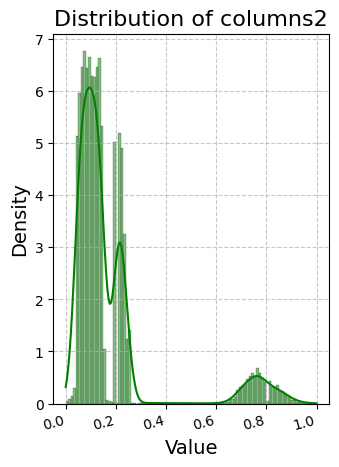

gk_diving


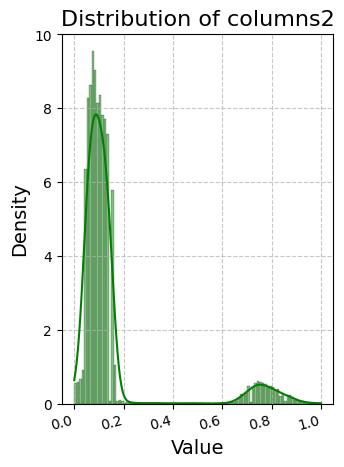

standing_tackle


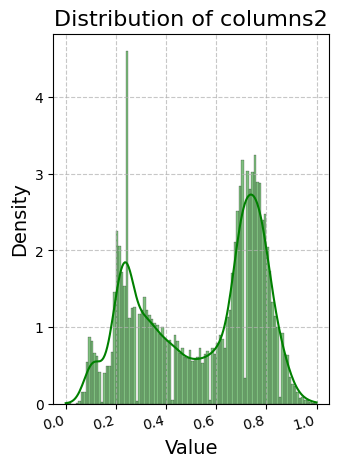

interceptions


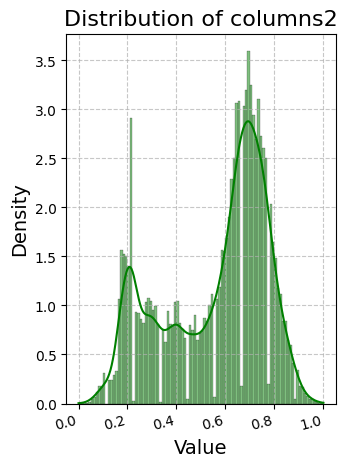

finishing


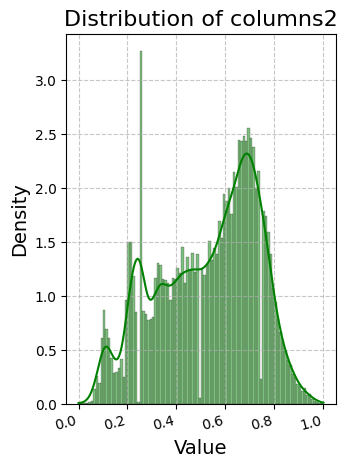

positioning


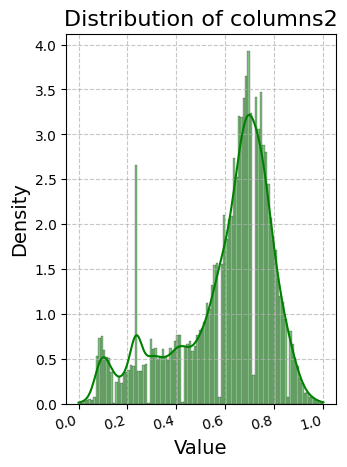

In [24]:
import seaborn as sns
for att in list_attributes:
    print(f'{att}')
    attributes = normalized_table.sort_values(by=f'{att}', ascending=False)

    plt.subplot(1, 2, 2)
    sns.histplot(attributes[f'{att}'], kde=True, color='green', stat='density', bins=100, line_kws={"color": "red"})
    plt.title('Distribution of columns2', fontsize=16)
    plt.xlabel('Value', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.xticks(rotation=15, ha='right')
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    
    

In [25]:
players_analys = players_analys.groupby(['season', 'player_name'])[['overall_rating','potential']].mean().reset_index()
players_analys = players_analys.sort_values(by=['season', 'overall_rating'], ascending=[True, False])

In [26]:
def create_player_per_season_dict(players_analys):
    player_per_season_dict = {}
    seen_players = []
    for index, row in players_analys.iterrows():
        season = row['season']
        player_name = row['player_name']
        # Add player to the dictionary if this is the first time the player appears in the season
        if season not in player_per_season_dict and player_name not in seen_players:
            player_per_season_dict[season] = player_name
            seen_players.append(player_name)
    return player_per_season_dict
    
player_per_season_dict = create_player_per_season_dict(players_analys)

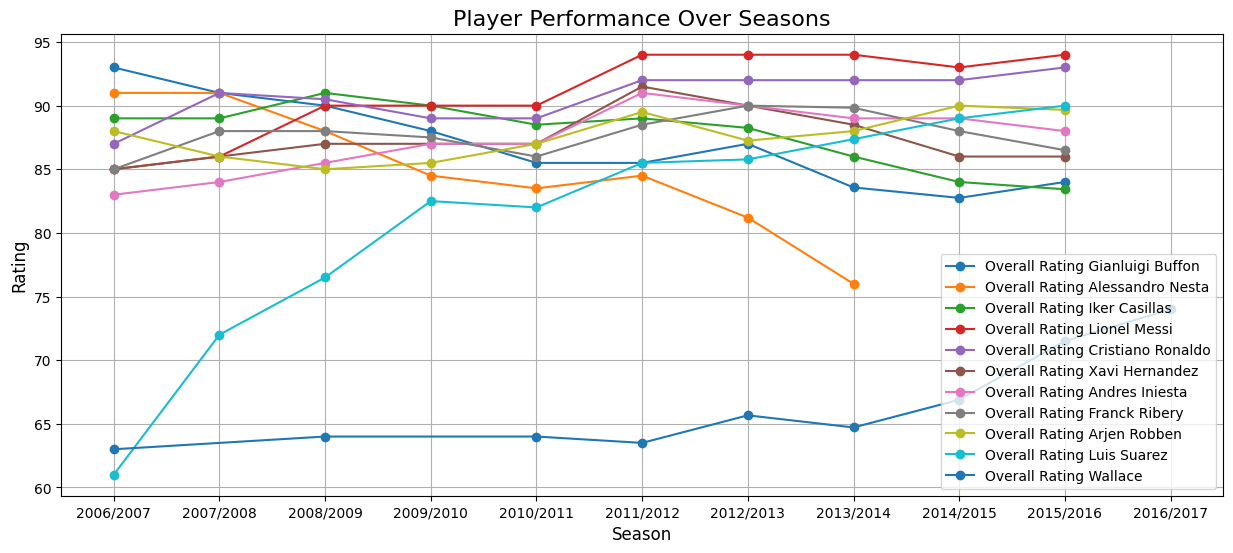

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))
for player in player_per_season_dict.values():
    df = players_analys[players_analys['player_name'] == player]
    plt.plot(df["season"], df["overall_rating"], marker="o", label=f"Overall Rating {player}")
plt.title(f"Player Performance Over Seasons", fontsize=16)
plt.xlabel("Season", fontsize=12)
plt.ylabel("Rating", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()



analys teams

In [28]:

match_columns = Match_df[['league_id','stage','season','home_team_api_id','away_team_api_id','home_team_goal','away_team_goal']]
analys_team = pd.merge(match_columns, Team_name, left_on='home_team_api_id', right_on='team_api_id', how='inner')
analys_team.drop(columns=['team_api_id', 'home_team_api_id'], inplace=True)

analys_team = analys_team.rename(columns={'team_long_name': 'home_team'})
analys_team = pd.merge(analys_team, Team_name, left_on='away_team_api_id', right_on='team_api_id', how='inner')
analys_team.drop(columns=['team_api_id', 'away_team_api_id'], inplace=True)
analys_team = analys_team.rename(columns={'team_long_name': 'away_team'})

analys_team = pd.merge(analys_team, League_name, left_on='league_id', right_on='country_id', how='inner')
analys_team.drop(columns=['league_id'], inplace=True)
analys_team = analys_team.rename(columns={'name': 'league_id'})

In [29]:
analys_team['result'] = analys_team.apply(lambda row: 'home' if row['home_team_goal'] > row['away_team_goal'] 
                        else ('away' if row['away_team_goal'] > row['home_team_goal'] 
                              else 'draw'), axis=1)

analys_team[analys_team['result']== 'draw'].count()

stage             6596
season            6596
home_team_goal    6596
away_team_goal    6596
home_team         6596
away_team         6596
country_id        6596
league_id         6596
result            6596
dtype: int64

In [30]:

home_results = analys_team.groupby(['league_id', 'home_team'])['result'].value_counts().unstack(fill_value=0)

away_results = analys_team.groupby(['league_id', 'away_team'])['result'].value_counts().unstack(fill_value=0)

In [31]:
away_results

result                                            away  draw  home
league_id                away_team                                
Belgium Jupiler League   Beerschot AC               10    17    49
                         Club Brugge KV             48    22    36
                         FCV Dender EH               4     4     9
                         KAA Gent                   46    36    27
                         KAS Eupen                   2     5     8
...                                                ...   ...   ...
Switzerland Super League FC Zürich                  58    31    54
                         Grasshopper Club Zürich    44    37    62
                         Lugano                      3     4    11
                         Neuchâtel Xamax            14    14    35
                         Servette FC                 9     7    19

[296 rows x 3 columns]

In [32]:
final_possession_table = final_possession_table[final_possession_table['AwayPos'].notna()]
team_possision = final_possession_table.set_index('id_match').join(Match_df, how='inner')
team_possision_final = team_possision[['league_id','home_team_api_id','HomePos','away_team_api_id','AwayPos']]
team_possision_final = pd.merge(team_possision_final, Team_name, left_on='home_team_api_id', right_on='team_api_id', how='inner')
team_possision_final = team_possision_final.rename(columns={'team_long_name': 'home_team_api'})
team_possision_final.drop(columns=['home_team_api_id', 'team_api_id'], inplace=True)


team_possision_final = pd.merge(team_possision_final, Team_name, left_on='away_team_api_id', right_on='team_api_id', how='inner')
team_possision_final = team_possision_final.rename(columns={'team_long_name': 'away_team_api'})
team_possision_final.drop(columns=['team_api_id', 'away_team_api_id'], inplace=True)

team_possision_final = pd.merge(League_name, team_possision_final, left_on='country_id', right_on='league_id', how='inner')
team_possision_final = team_possision_final.rename(columns={'name': 'league_name'})
team_possision_final.drop(columns=['country_id','league_id'], inplace=True)

In [33]:
team_possision_final[team_possision_final['home_team_api'] == 'Manchester United']
home_team_possision = team_possision_final[['league_name','home_team_api','HomePos']]
away_team_possision = team_possision_final[['league_name','away_team_api','AwayPos']]


In [34]:
away_team_possision['AwayPos'] = pd.to_numeric(away_team_possision['AwayPos'])
home_team_possision['HomePos'] = pd.to_numeric(home_team_possision['HomePos'])


home_team_possision = home_team_possision.groupby(['league_name', 'home_team_api'])[['HomePos']].median().reset_index()
away_team_possision = away_team_possision.groupby(['league_name', 'away_team_api'])[['AwayPos']].median().reset_index()

home_team_possision = home_team_possision.sort_values(by=['league_name', 'HomePos'], ascending=[True, False])
away_team_possision = away_team_possision.sort_values(by=['league_name', 'AwayPos'], ascending=[True, False])

a = away_team_possision[(away_team_possision['away_team_api'] == 'Arsenal') | (away_team_possision['away_team_api'] == 'Borussia Dortmund') | (away_team_possision['away_team_api'] == 'Manchester United') | (away_team_possision['away_team_api'] == 'Paris Saint-Germain')]
b = home_team_possision[(home_team_possision['home_team_api'] == 'Arsenal') | (home_team_possision['home_team_api'] == 'Borussia Dortmund') | (home_team_possision['home_team_api'] == 'Manchester United') | (home_team_possision['home_team_api'] == 'Paris Saint-Germain')]

display(a)
display(b)



/tmp/ipykernel_110947/604861359.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  away_team_possision['AwayPos'] = pd.to_numeric(away_team_possision['AwayPos'])
/tmp/ipykernel_110947/604861359.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  home_team_possision['HomePos'] = pd.to_numeric(home_team_possision['HomePos'])


,league_name,away_team_api,AwayPos
17,England Premier League,Manchester United,48.0
0,England Premier League,Arsenal,46.0
55,France Ligue 1,Paris Saint-Germain,46.0
70,Germany 1. Bundesliga,Borussia Dortmund,47.0


,league_name,home_team_api,HomePos
0,England Premier League,Arsenal,51.0
17,England Premier League,Manchester United,51.0
55,France Ligue 1,Paris Saint-Germain,53.0
70,Germany 1. Bundesliga,Borussia Dortmund,52.0


In [35]:
away_results = away_results.rename(columns={'away': 'win', 'draw': 'égalité', 'home': 'lose'})
home_results = home_results.rename(columns={'away': 'lose', 'draw': 'égalité', 'home': 'win'})
home_results = home_results.query('(home_team == "Arsenal")|(home_team == "Borussia Dortmund")|(home_team == "Paris Saint-Germain")|(home_team == "Manchester United")')
away_results = away_results.query('(away_team == "Arsenal")|(away_team == "Borussia Dortmund")|(away_team == "Paris Saint-Germain")|(away_team == "Manchester United")')
display(home_results)
display(away_results)

result                                      lose  égalité  win
league_id              home_team                              
England Premier League Arsenal                21       34   97
                       Manchester United      20       16  116
France Ligue 1         Paris Saint-Germain    18       32  102
Germany 1. Bundesliga  Borussia Dortmund      18       30   88

result                                      win  égalité  lose
league_id              away_team                              
England Premier League Arsenal               73       39    40
                       Manchester United     76       41    35
France Ligue 1         Paris Saint-Germain   73       44    35
Germany 1. Bundesliga  Borussia Dortmund     69       32    35

In [36]:
# plt.figure(figsize=(20, 10))
# plt.bar(d['away_team_api'], d['AwayPos'], color='green')
# plt.title('')
# plt.xlabel('')
# plt.ylabel('')
# plt.xticks(rotation=15, ha='right')
# plt.tight_layout()
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.show()
# #"""""""
# plt.figure(figsize=(20, 4))
# plt.bar(c['home_team_api'], c['HomePos'], color='red')
# plt.title('')
# plt.xlabel('')
# plt.ylabel('')
# plt.xticks(rotation=15, ha='right')
# plt.tight_layout()
# plt.grid(True, linestyle='--', alpha=0.7)
# plt.show()

In [37]:
analyse_team_att = Team_Attributes_df

analyse_team_att = analyse_team_att.drop(columns=['id','team_fifa_api_id','date'], inplace=False)

In [38]:
analyse_team_att.isna().sum()

team_api_id                         0
buildUpPlaySpeed                    0
buildUpPlaySpeedClass               0
buildUpPlayDribbling              969
buildUpPlayDribblingClass           0
buildUpPlayPassing                  0
buildUpPlayPassingClass             0
buildUpPlayPositioningClass         0
chanceCreationPassing               0
chanceCreationPassingClass          0
chanceCreationCrossing              0
chanceCreationCrossingClass         0
chanceCreationShooting              0
chanceCreationShootingClass         0
chanceCreationPositioningClass      0
defencePressure                     0
defencePressureClass                0
defenceAggression                   0
defenceAggressionClass              0
defenceTeamWidth                    0
defenceTeamWidthClass               0
defenceDefenderLineClass            0
dtype: int64

In [39]:
mean_values = analyse_team_att.groupby(['buildUpPlayDribblingClass'])['buildUpPlayDribbling'].mean().reset_index()
def fill_nan(row, mean_values):
    if pd.isna(row['buildUpPlayDribbling']):
        class_name = row['buildUpPlayDribblingClass']
        
        mean_value = mean_values[mean_values['buildUpPlayDribblingClass'] == class_name]['buildUpPlayDribbling'].values

        if mean_value.size > 0:
            return mean_value[0]
        else:
            return np.nan 
    return row['buildUpPlayDribbling']

analyse_team_att['buildUpPlayDribbling'] = analyse_team_att.apply(lambda row: fill_nan(row, mean_values), axis=1)

In [40]:
analyse_team_att.isna().sum()

team_api_id                       0
buildUpPlaySpeed                  0
buildUpPlaySpeedClass             0
buildUpPlayDribbling              0
buildUpPlayDribblingClass         0
buildUpPlayPassing                0
buildUpPlayPassingClass           0
buildUpPlayPositioningClass       0
chanceCreationPassing             0
chanceCreationPassingClass        0
chanceCreationCrossing            0
chanceCreationCrossingClass       0
chanceCreationShooting            0
chanceCreationShootingClass       0
chanceCreationPositioningClass    0
defencePressure                   0
defencePressureClass              0
defenceAggression                 0
defenceAggressionClass            0
defenceTeamWidth                  0
defenceTeamWidthClass             0
defenceDefenderLineClass          0
dtype: int64

In [41]:
team_analyse = analyse_team_att[
        ['team_api_id', 'buildUpPlaySpeed','buildUpPlayDribbling','buildUpPlayPassing', 'chanceCreationPassing','chanceCreationCrossing','chanceCreationShooting','defencePressure', 'defenceAggression', 'defenceTeamWidth']
]
team_analyse = team_analyse.groupby(['team_api_id'])[
        ['buildUpPlaySpeed','buildUpPlayDribbling','buildUpPlayPassing', 'chanceCreationPassing','chanceCreationCrossing','chanceCreationShooting','defencePressure', 'defenceAggression', 'defenceTeamWidth']
].mean() 


In [42]:
team_analyse = pd.merge(Team_name, team_analyse, left_on='team_api_id', right_on='team_api_id', how='inner')
team_analyse


,team_api_id,team_long_name,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth
0,9987,KRC Genk,56.333333,37.657143,44.333333,55.666667,52.333333,55.833333,49.166667,50.666667,59.833333
1,9993,Beerschot AC,46.000000,30.485714,41.500000,46.000000,53.500000,53.750000,48.250000,49.000000,58.750000
2,10000,SV Zulte-Waregem,55.500000,34.323810,52.666667,50.000000,49.333333,41.500000,48.666667,56.166667,47.833333
3,9994,Sporting Lokeren,64.000000,35.323810,53.500000,44.000000,47.666667,54.333333,48.833333,55.166667,55.500000
4,9984,KSV Cercle Brugge,53.666667,36.657143,44.166667,59.000000,60.333333,48.000000,60.166667,49.666667,64.666667
...,...,...,...,...,...,...,...,...,...,...,...
283,10243,FC Zürich,56.833333,36.657143,50.000000,48.000000,55.166667,53.500000,48.666667,46.000000,55.666667
284,10190,FC St. Gallen,47.600000,36.691429,51.800000,39.800000,45.200000,44.400000,43.800000,45.600000,50.800000
285,10191,FC Thun,56.600000,41.891429,35.800000,63.200000,36.400000,59.000000,45.000000,42.800000,51.600000
286,9777,Servette FC,42.000000,30.485714,52.333333,50.333333,67.333333,50.000000,51.000000,50.000000,51.000000


analys matchs


In [43]:
analys_team

,stage,season,home_team_goal,away_team_goal,home_team,away_team,country_id,league_id,result
0,1,2008/2009,1,1,KRC Genk,Beerschot AC,1,Belgium Jupiler League,draw
1,1,2008/2009,0,0,SV Zulte-Waregem,Sporting Lokeren,1,Belgium Jupiler League,draw
2,1,2008/2009,0,3,KSV Cercle Brugge,RSC Anderlecht,1,Belgium Jupiler League,away
3,1,2008/2009,5,0,KAA Gent,RAEC Mons,1,Belgium Jupiler League,home
4,1,2008/2009,1,3,FCV Dender EH,Standard de Liège,1,Belgium Jupiler League,away
...,...,...,...,...,...,...,...,...,...
25974,9,2015/2016,1,0,FC St. Gallen,FC Thun,24558,Switzerland Super League,home
25975,9,2015/2016,1,2,FC Vaduz,FC Luzern,24558,Switzerland Super League,away
25976,9,2015/2016,2,0,Grasshopper Club Zürich,FC Sion,24558,Switzerland Super League,home
25977,9,2015/2016,0,0,Lugano,FC Zürich,24558,Switzerland Super League,draw


In [44]:
analys_team['scores'] = analys_team.apply(lambda row: row['home_team_goal'] + row['away_team_goal'] , axis=1)

analys_team[analys_team['scores'] == 0].count()

stage             1978
season            1978
home_team_goal    1978
away_team_goal    1978
home_team         1978
away_team         1978
country_id        1978
league_id         1978
result            1978
scores            1978
dtype: int64

In [45]:
analys_team #= analys_team.sort_values(by='season', ascending=False)

,stage,season,home_team_goal,away_team_goal,home_team,away_team,country_id,league_id,result,scores
0,1,2008/2009,1,1,KRC Genk,Beerschot AC,1,Belgium Jupiler League,draw,2
1,1,2008/2009,0,0,SV Zulte-Waregem,Sporting Lokeren,1,Belgium Jupiler League,draw,0
2,1,2008/2009,0,3,KSV Cercle Brugge,RSC Anderlecht,1,Belgium Jupiler League,away,3
3,1,2008/2009,5,0,KAA Gent,RAEC Mons,1,Belgium Jupiler League,home,5
4,1,2008/2009,1,3,FCV Dender EH,Standard de Liège,1,Belgium Jupiler League,away,4
...,...,...,...,...,...,...,...,...,...,...
25974,9,2015/2016,1,0,FC St. Gallen,FC Thun,24558,Switzerland Super League,home,1
25975,9,2015/2016,1,2,FC Vaduz,FC Luzern,24558,Switzerland Super League,away,3
25976,9,2015/2016,2,0,Grasshopper Club Zürich,FC Sion,24558,Switzerland Super League,home,2
25977,9,2015/2016,0,0,Lugano,FC Zürich,24558,Switzerland Super League,draw,0


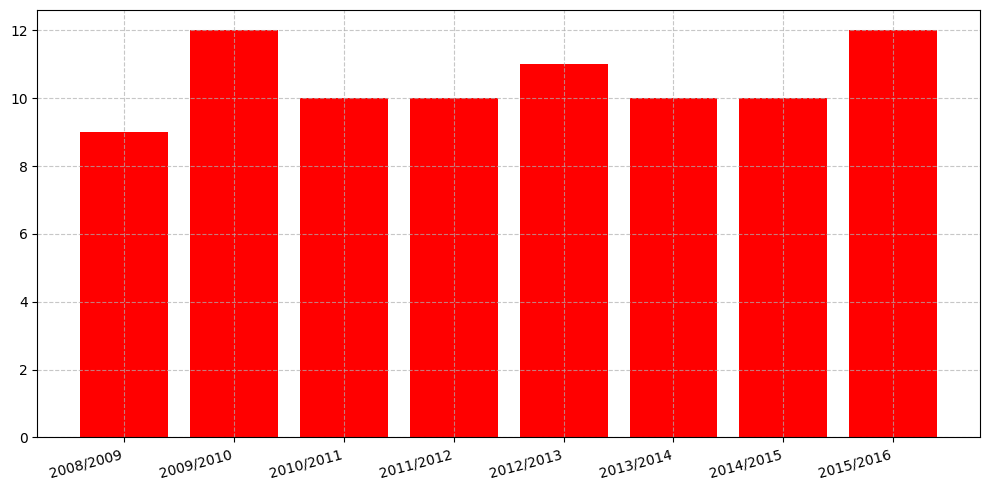

In [46]:
plt.figure(figsize=(10, 5))
plt.bar(analys_team['season'], analys_team['scores'], color='red')
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

In [47]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

analys_team[analys_team['away_team']== 'Real Madrid CF']
matchs_domicile = analys_team[['home_team','home_team_goal']]
matchs_domicile = matchs_domicile.sort_values(by='home_team', ascending=False) 
matchs_exterieur = analys_team[['away_team','away_team_goal']]
matchs_exterieur = matchs_exterieur.sort_values(by='away_team', ascending=False) 
merge_table_away_home = pd.merge(matchs_exterieur, matchs_domicile, left_on='away_team', right_on='home_team', how='inner')
merge_table_away_home.drop(columns=['away_team'], inplace=True)
merge_table_away_home = merge_table_away_home.rename(columns={'home_team': 'Team'})
merge_table_away_home = merge_table_away_home[['Team','home_team_goal','away_team_goal']]
merge_table_away_home['Team_code'] = label_encoder.fit_transform(merge_table_away_home['Team'])

merge_table_away_home

,Team,home_team_goal,away_team_goal,Team_code
0,Śląsk Wrocław,0,0,295
1,Śląsk Wrocław,0,0,295
2,Śląsk Wrocław,2,0,295
3,Śląsk Wrocław,1,0,295
4,Śląsk Wrocław,1,0,295
...,...,...,...,...
2964293,1. FC Kaiserslautern,0,0,0
2964294,1. FC Kaiserslautern,5,0,0
2964295,1. FC Kaiserslautern,3,0,0
2964296,1. FC Kaiserslautern,3,0,0


In [48]:
Player_A_merged_df

,season,player_name,gk_reflexes,gk_diving,standing_tackle,interceptions,finishing,positioning
0,2006/2007,Aaron Galindo,10.0,14.0,70.0,54.0,50.0,68.0
1,2006/2007,Aaron Hughes,6.0,12.0,79.0,74.0,57.0,76.0
2,2006/2007,Aaron Hunt,9.0,9.0,25.0,67.0,69.0,73.0
3,2006/2007,Aaron Lennon,14.0,12.0,29.0,73.0,61.0,76.0
4,2006/2007,Aaron Mokoena,6.0,6.0,79.0,68.0,58.0,62.0
...,...,...,...,...,...,...,...,...
47036,2016/2017,Bebe,11.0,15.0,24.0,24.0,67.0,67.0
47037,2016/2017,Florian Lejeune,7.0,11.0,75.0,72.0,42.0,46.0
47038,2016/2017,Jhon Murillo,12.0,7.0,18.0,17.0,64.0,61.0
47039,2016/2017,Ronnie Schwartz,14.0,13.0,17.0,37.0,70.0,75.0


clustring : players

In [49]:
analys_player = Player_A_merged_df
analys_player = analys_player.groupby('player_name')[['gk_reflexes','gk_diving','standing_tackle','interceptions','finishing','positioning']].mean().reset_index()

In [50]:
analys_player[analys_player['player_name']=='Aaron Appindangoye']

,player_name,gk_reflexes,gk_diving,standing_tackle,interceptions,finishing,positioning
0,Aaron Appindangoye,8.0,6.0,69.0,70.0,44.0,45.0


In [51]:
from sklearn.preprocessing import MinMaxScaler

columns_to_normalize = ['gk_reflexes', 'gk_diving', 'standing_tackle', 'interceptions',
                       'finishing', 'positioning']

scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(analys_player[columns_to_normalize])

normalized_table = pd.DataFrame(normalized_data, columns=columns_to_normalize)
normalized_table

,gk_reflexes,gk_diving,standing_tackle,interceptions,finishing,positioning
0,0.076965,0.055804,0.742002,0.751491,0.451737,0.458101
1,0.112150,0.136161,0.776061,0.665606,0.530502,0.589944
2,0.136653,0.146684,0.159869,0.494178,0.628792,0.659218
3,0.100177,0.146329,0.767006,0.638834,0.302445,0.441341
4,0.128642,0.090402,0.839314,0.824254,0.436680,0.490503
...,...,...,...,...,...,...
8733,0.186916,0.058036,0.662936,0.735984,0.465637,0.648045
8734,0.204508,0.145089,0.812553,0.782505,0.440154,0.607821
8735,0.130370,0.089286,0.283247,0.536779,0.773580,0.799681
8736,0.162727,0.109375,0.700645,0.675149,0.600000,0.659218


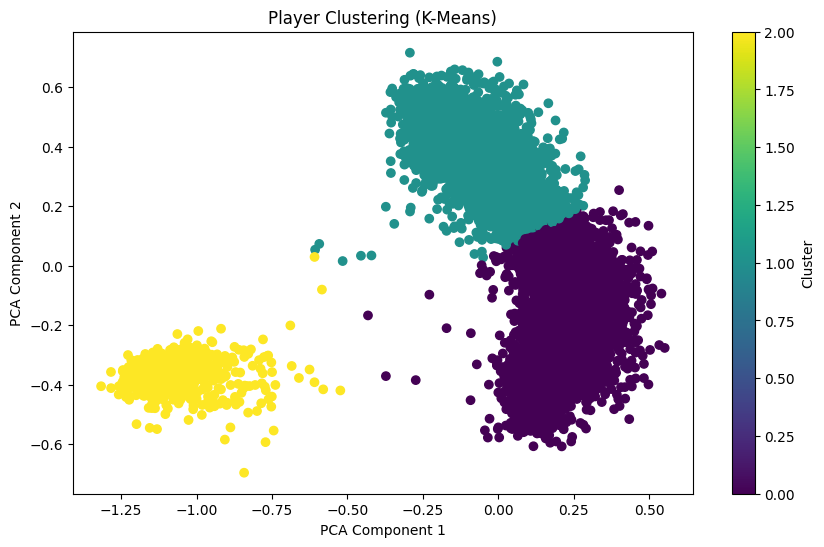

In [75]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
kmeans = KMeans(n_clusters=3, random_state=42)
analys_player['cluster_kmeans'] = kmeans.fit_predict(normalized_data)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(normalized_data)
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=analys_player['cluster_kmeans'], cmap='viridis')
plt.title('Player Clustering (K-Means)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [76]:
cluster_means = analys_player.groupby('cluster_kmeans')[columns_to_normalize].mean()
cluster_means

,gk_reflexes,gk_diving,standing_tackle,interceptions,finishing,positioning
cluster_kmeans,,,,,,
0,12.594903,9.943662,69.172276,67.409418,43.148854,55.073190
1,12.280025,9.929139,33.082004,41.227689,67.689505,68.332274
2,73.264243,71.498347,19.468174,30.371607,18.215033,22.350304


In [77]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(normalized_data, analys_player['cluster_kmeans'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.5391836012739353


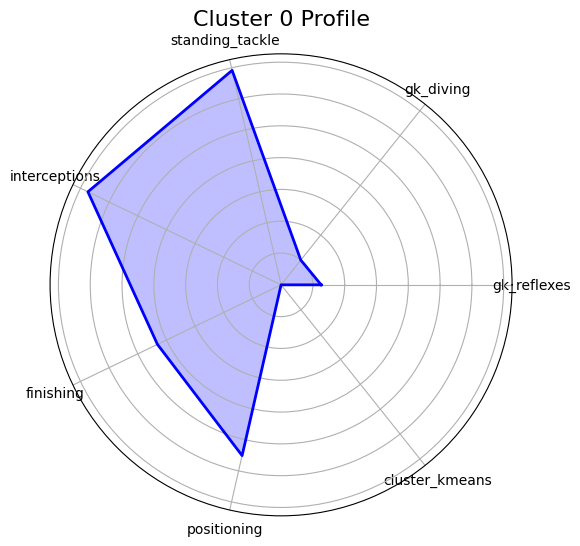

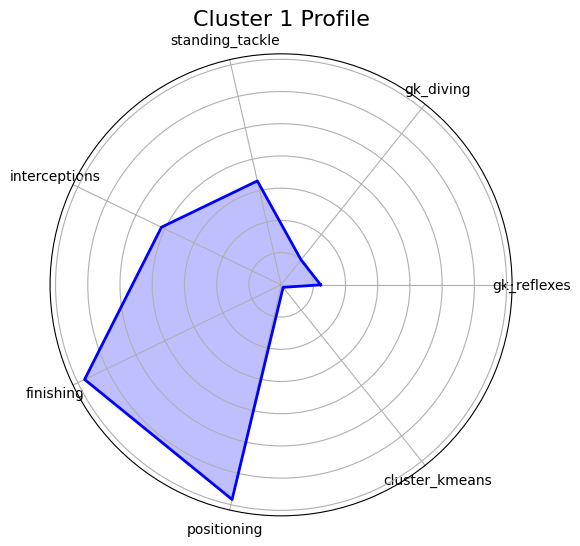

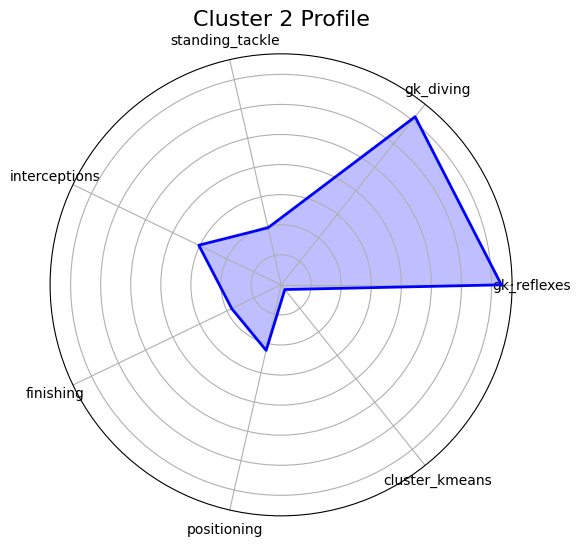

In [56]:
import numpy as np

def radar_chart(cluster_data, cluster_name):
    numeric_data = cluster_data.select_dtypes(include=[np.number])
    
    values = numeric_data.mean(axis=0).values
    
    categories = numeric_data.columns  
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()

    values = np.concatenate((values, [values[0]]))
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.fill(angles, values, color='blue', alpha=0.25)
    ax.plot(angles, values, color='blue', linewidth=2)
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, rotation=45)
    ax.set_title(f'Cluster {cluster_name} Profile', fontsize=16)
    plt.show()

for cluster in range(3):  # Assuming you have 3 clusters
    cluster_data = analys_player[analys_player['cluster_kmeans'] == cluster]
    radar_chart(cluster_data, cluster)

clustring : teams

In [67]:
team_analyse[team_analyse['buildUpPlayDribbling'] >= 60]

,team_api_id,team_long_name,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,cluster_kmeans
221,158085,FC Arouca,67.0,66.0,39.0,55.0,59.0,46.0,36.0,38.0,37.0,1


In [68]:


columns_normalize = ['buildUpPlaySpeed','buildUpPlayDribbling','buildUpPlayPassing', 'chanceCreationPassing','chanceCreationCrossing','chanceCreationShooting','defencePressure', 'defenceAggression', 'defenceTeamWidth']

scaler = MinMaxScaler()
normalized = scaler.fit_transform(team_analyse[columns_normalize])

normalized_table = pd.DataFrame(normalized, columns=columns_normalize)
normalized_table

,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,defencePressure,defenceAggression,defenceTeamWidth
0,0.625483,0.212907,0.304965,0.530075,0.516667,0.745833
1,0.386100,0.013753,0.244681,0.509398,0.475000,0.718750
2,0.606178,0.120339,0.482270,0.518797,0.654167,0.445833
3,0.803089,0.148109,0.500000,0.522556,0.629167,0.637500
4,0.563707,0.185136,0.301418,0.778195,0.491667,0.866667
...,...,...,...,...,...,...
283,0.637066,0.185136,0.425532,0.518797,0.400000,0.641667
284,0.423166,0.186088,0.463830,0.409023,0.390000,0.520000
285,0.631660,0.330495,0.123404,0.436090,0.320000,0.540000
286,0.293436,0.013753,0.475177,0.571429,0.500000,0.525000


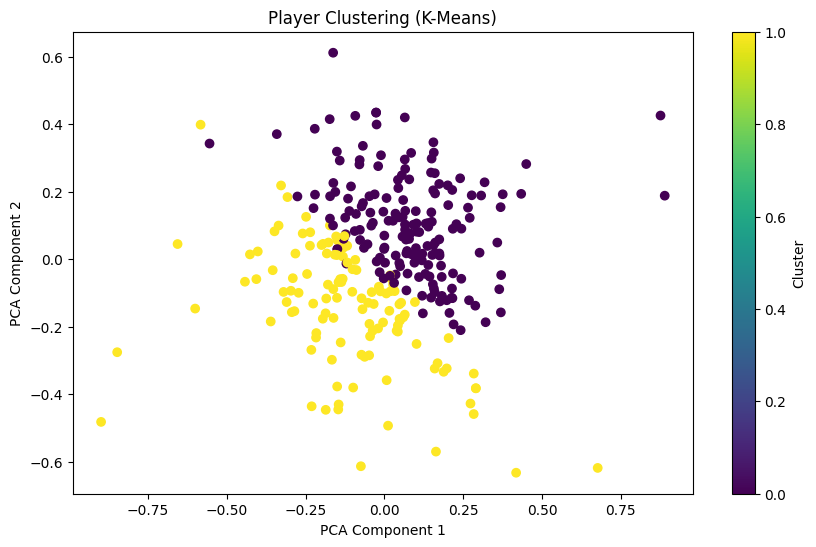

In [69]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=2, random_state=42)
team_analyse['cluster_kmeans'] = kmeans.fit_predict(normalized)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(normalized)
plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=team_analyse['cluster_kmeans'], cmap='viridis')
plt.title('Player Clustering (K-Means)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [70]:
cluster_means_team = team_analyse.groupby('cluster_kmeans')[columns_normalize].mean()
cluster_means_team

,buildUpPlaySpeed,buildUpPlayDribbling,buildUpPlayPassing,defencePressure,defenceAggression,defenceTeamWidth
cluster_kmeans,,,,,,
0,56.380000,37.394924,51.444804,46.829314,50.899902,53.404902
1,45.754661,35.815924,44.806497,44.368785,46.637853,50.083898


In [71]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(normalized, team_analyse['cluster_kmeans'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.16647987143215523
